In [1]:
import os

import pandas as pd

In [2]:
# create .csv file_path from this folder "/Users/user/Documents/Coding/geo/notebook/data/crop_image"ArithmeticError
image_folder_path = "/Users/user/Documents/Coding/geo/notebook/data/crop_image"
image_name_list = os.listdir(image_folder_path)
image_name_list = [
    image_name for image_name in image_name_list if not image_name.startswith(".")
]
image_path_list = [
    os.path.join(image_folder_path, image_name) for image_name in image_name_list
]
# create csv id,path,label
image_df = pd.DataFrame(
    {
        "id": [str(i) for i in range(len(image_path_list))],
        "path": image_path_list,
        "label": "no label",
    }
)
image_df.to_csv("./image.csv", index=False)

In [3]:
df_path = "./df_embedding.pkl"
df = pd.read_pickle(df_path)
df.head()

,store_id,prov_namt,latitude,longitude,embedding
0,1025,กรุงเทพมหานคร,13.838724,100.575318,[]
1,1026,ปทุมธานี,14.036545,100.733520,[]
2,1028,ตรัง,7.567873,99.614094,[]
3,1032,กรุงเทพมหานคร,13.719625,100.442061,[]
4,1033,กรุงเทพมหานคร,13.768390,100.721288,[]


In [4]:
# drop df if embedding is []
df = df[df["embedding"].map(lambda d: len(d)) > 0]
df.head()

,store_id,prov_namt,latitude,longitude,embedding
12,1041,นครศรีธรรมราช,8.438235,99.970407,"[0.10472209751605988, -0.8688017129898071, 0.4..."
13,1043,ชัยนาท,15.261956,100.038846,"[-0.9744595289230347, -0.15048906207084656, -0..."
14,8686,กรุงเทพมหานคร,13.681274,100.336079,"[-0.5645326972007751, -0.7172844409942627, 0.0..."
15,1046,กรุงเทพมหานคร,13.730781,100.586291,"[-0.2817739248275757, -0.6421278715133667, -0...."
16,1053,พิจิตร,16.168107,100.578477,"[-0.513382613658905, -0.9152358174324036, -0.3..."


In [5]:
df.shape

(9985, 5)

In [6]:
import csv
from glob import glob
from pathlib import Path
from statistics import mean

from towhee import pipe, ops, DataCollection
from pymilvus import (
    connections,
    FieldSchema,
    CollectionSchema,
    DataType,
    Collection,
    utility,
)


# Towhee parameters
MODEL = "maxvit_tiny_tf_512"
DEVICE = "mps"  # if None, use default device (cuda is enabled if available)

# Milvus parameters
HOST = "127.0.0.1"
PORT = "19530"
TOPK = 10
DIM = 512  # dimension of embedding extracted by MODEL
COLLECTION_NAME = "reverse_image_search"
INDEX_TYPE = "IVF_FLAT"
METRIC_TYPE = "L2"

# path to csv (column_1 indicates image path) OR a pattern of image paths
INSERT_SRC = "/Users/user/Documents/Coding/geo/notebook/image.csv"
QUERY_SRC = "/Users/user/Documents/Coding/geo/notebook/data/crop_image/*.png"

In [7]:
# Load image path
def load_image(x):
    if x.endswith("csv"):
        with open(x) as f:
            reader = csv.reader(f)
            next(reader)
            for item in reader:
                yield item[1]
    else:
        for item in glob(x):
            yield item


# Embedding pipeline
p_embed = (
    pipe.input("src")
    .flat_map("src", "img_path", load_image)
    .map("img_path", "img", ops.image_decode())
    .map("img", "vec", ops.image_embedding.timm(model_name=MODEL, device=DEVICE))
)

img_path,img,vec
/Users/user/Documents/Coding/geo/notebook/data/crop_image/1025.png,,"[-4.2316446, 4.275291, -0.43613064, ...] shape=(512,)"

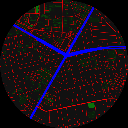

<Figure size 128x128 with 0 Axes>

In [8]:
# Display embedding result, no need for implementation
p_display = p_embed.output("img_path", "img", "vec")
DataCollection(
    p_display("/Users/user/Documents/Coding/geo/notebook/data/crop_image/1025.png")
).show()

In [9]:
# Create milvus collection (delete first if exists)
def create_milvus_collection(collection_name, dim):
    if utility.has_collection(collection_name):
        # if it has collection connect to it
        return Collection(name=collection_name)
        # utility.drop_collection(collection_name)

    fields = [
        FieldSchema(
            name="path",
            dtype=DataType.VARCHAR,
            description="path to image",
            max_length=500,
            is_primary=True,
            auto_id=False,
        ),
        FieldSchema(
            name="embedding",
            dtype=DataType.FLOAT_VECTOR,
            description="image embedding vectors",
            dim=dim,
        ),
    ]
    schema = CollectionSchema(fields=fields, description="reverse image search")
    collection = Collection(name=collection_name, schema=schema)

    index_params = {
        "metric_type": METRIC_TYPE,
        "index_type": INDEX_TYPE,
        "params": {"nlist": 2048},
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    return collection

In [10]:
# Connect to Milvus service
connections.connect(host=HOST, port=PORT)

# Create collection
collection = create_milvus_collection(COLLECTION_NAME, DIM)
print(f"A new collection created: {COLLECTION_NAME}")

A new collection created: reverse_image_search


In [11]:
# Insert pipeline
p_insert = p_embed.map(
    ("img_path", "vec"),
    "mr",
    ops.ann_insert.milvus_client(host=HOST, port=PORT, collection_name=COLLECTION_NAME),
).output("mr")

In [12]:
collection.num_entities

15365

In [13]:
# # Insert data
# p_insert(INSERT_SRC)

# # Check collection
# print("Number of data inserted:", collection.num_entities)

In [14]:
# Search pipeline
p_search_pre = (
    p_embed.map(
        "vec",
        ("search_res"),
        ops.ann_search.milvus_client(
            host=HOST, port=PORT, limit=TOPK, collection_name=COLLECTION_NAME
        ),
    ).map("search_res", "pred", lambda x: [str(Path(y[0]).resolve()) for y in x])
    #                .output('img_path', 'pred')
)
p_search = p_search_pre.output("img_path", "pred")

In [15]:
# Search for example query image(s)
collection.load()
dc = p_search("/Users/user/Documents/Coding/geo/notebook/data/crop_image/2369.png")

# Display search results with image paths
DataCollection(dc).show()

img_path,pred
/Users/user/Documents/Coding/geo/notebook/data/crop_image/2369.png,/Users/user/Documents/Coding/geo/notebook/data/crop_image/2369.png /Users/user/Documents/Coding/geo/notebook/data/crop_image/10599.png /Users/user/Documents/Coding/geo/notebook/data/crop_image/14598.png /Users/user/Documents/Coding/geo/notebook/data/crop_image/10453.png /Users/user/Documents/Coding/geo/notebook/data/crop_image/18168.png /Users/user/Documents/Coding/geo/notebook/data/crop_image/9565.png


In [16]:
# Display search results with images, no need for implementation
# Search pipeline
p_search_pre = (
    p_embed.map(
        "vec",
        ("search_res"),
        ops.ann_search.milvus_client(
            host=HOST,
            port=PORT,
            # limit=TOPK,
            limit=20,
            collection_name=COLLECTION_NAME,
        ),
    ).map("search_res", "pred", lambda x: [str(Path(y[0]).resolve()) for y in x])
    #                .output('img_path', 'pred')
)
p_search = p_search_pre.output("img_path", "pred")
import cv2
from towhee.types.image import Image


def read_images(img_paths):
    imgs = []
    for p in img_paths:
        imgs.append(Image(cv2.imread(p), "RGB"))
    return imgs


p_search_img = p_search_pre.map("pred", "pred_images", read_images).output(
    "img", "pred_images"
)
result = DataCollection(
    p_search_img("/Users/user/Documents/Coding/geo/notebook/data/crop_image/2369.png")
)

img,pred_images
,

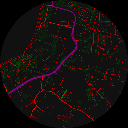
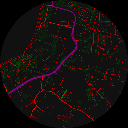
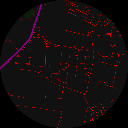
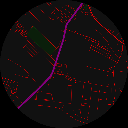
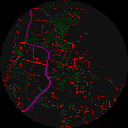
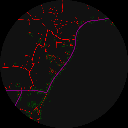
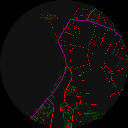
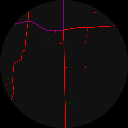
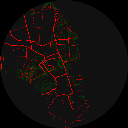
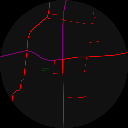
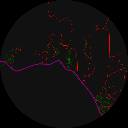
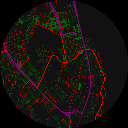
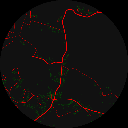

In [17]:
result.show()

In [18]:
result.__dict__

{'_schema': ['img', 'pred_images'],
 '_type_schema': [<ColumnType.QUEUE: 1>, <ColumnType.QUEUE: 1>],
 '_iterable': [<Entity dict_keys(['img', 'pred_images'])>]}

In [19]:
result_list = result.to_list()

In [20]:
for r in result_list:
    print(r.__dict__.keys())

dict_keys(['img', 'pred_images'])


In [21]:
# Search pipeline
p_search_pre = (
    p_embed.map(
        "vec",
        ("search_res"),
        ops.ann_search.milvus_client(
            host=HOST,
            port=PORT,
            limit=TOPK + 1,
            collection_name=COLLECTION_NAME,
        ),
    )
    .map("search_res", "pred", lambda x: [str(Path(y[0]).resolve()) for y in x])
    .map("search_res", "score", lambda x: [y[1] for y in x])
    #                .output('img_path', 'pred')
)
p_search = p_search_pre.output("pred", "score")

In [22]:
dc = p_search("/Users/user/Documents/Coding/geo/notebook/data/crop_image/10049.png")
result = DataCollection(dc)
result.show()

pred,score
/Users/user/Documents/Coding/geo/notebook/data/crop_image/10049.png /Users/user/Documents/Coding/geo/notebook/data/crop_image/15195.png /Users/user/Documents/Coding/geo/notebook/data/crop_image/61.png /Users/user/Documents/Coding/geo/notebook/data/crop_image/5257.png /Users/user/Documents/Coding/geo/notebook/data/crop_image/597.png /Users/user/Documents/Coding/geo/notebook/data/crop_image/811.png /Users/user/Documents/Coding/geo/notebook/data/crop_image/14390.png,"[0.0,478.0536804199219,584.5744018554688,1248.159423828125,...] len=7"


In [23]:
result.__dict__

{'_schema': ['pred', 'score'],
 '_type_schema': [<ColumnType.QUEUE: 1>, <ColumnType.QUEUE: 1>],
 '_iterable': [<Entity dict_keys(['pred', 'score'])>]}

In [24]:
import pandas as pd

table_data = result.prepare_table_data()
print(table_data.keys())
table_data_dict = {}
for ind, key in enumerate(table_data["headers"]):
    table_data_dict[key] = table_data["data"][0][ind]
result_df = pd.DataFrame.from_dict(table_data_dict)
result_df

dict_keys(['data', 'headers'])


,pred,score
0,/Users/user/Documents/Coding/geo/notebook/data...,0.000000
1,/Users/user/Documents/Coding/geo/notebook/data...,478.053680
2,/Users/user/Documents/Coding/geo/notebook/data...,584.574402
3,/Users/user/Documents/Coding/geo/notebook/data...,1248.159424
4,/Users/user/Documents/Coding/geo/notebook/data...,1553.327393
5,/Users/user/Documents/Coding/geo/notebook/data...,2069.218018
6,/Users/user/Documents/Coding/geo/notebook/data...,2357.233154


In [25]:
def postprocess_df(df, result_df, max_num=TOPK):
    df = df.copy()
    result_df = result_df.copy()
    # drop first row
    result_df = result_df.iloc[1 : max_num + 1]
    # add new column file_name
    result_df["file_name"] = result_df["pred"].map(lambda x: x.split("/")[-1])
    # add new column store_id
    result_df["store_id"] = result_df["file_name"].map(lambda x: int(x.split(".")[0]))
    # store_id	prov_namt from df filter
    df = df[["store_id", "prov_namt"]]
    result_df = pd.merge(result_df, df, on="store_id", how="left")
    return result_df


new_df = postprocess_df(df, result_df)
new_df

,pred,score,file_name,store_id,prov_namt
0,/Users/user/Documents/Coding/geo/notebook/data...,478.053680,15195.png,15195,กรุงเทพมหานคร
1,/Users/user/Documents/Coding/geo/notebook/data...,584.574402,61.png,61,กรุงเทพมหานคร
2,/Users/user/Documents/Coding/geo/notebook/data...,1248.159424,5257.png,5257,กรุงเทพมหานคร
3,/Users/user/Documents/Coding/geo/notebook/data...,1553.327393,597.png,597,กรุงเทพมหานคร
4,/Users/user/Documents/Coding/geo/notebook/data...,2069.218018,811.png,811,กรุงเทพมหานคร
5,/Users/user/Documents/Coding/geo/notebook/data...,2357.233154,14390.png,14390,กรุงเทพมหานคร


In [26]:
df["prov_namt"].value_counts()

กรุงเทพมหานคร    2926
ชลบุรี            735
นนทบุรี           546
สมุทรปราการ       506
ปทุมธานี          445
                 ... 
ลำพูน               8
อำนาจเจริญ          7
แม่ฮ่องสอน          5
ยะลา                5
นราธิวาส            3
Name: prov_namt, Length: 77, dtype: int64

In [27]:
import random

# set seed
random.seed(41)

In [28]:
# random select 3 from df["prov_namt"].unique()
random_prov_namt = random.sample(list(df["prov_namt"].unique()), 3)
random_prov_namt

['ร้อยเอ็ด', 'เพชรบุรี', 'สมุทรสาคร']

In [29]:
selected_province_list = [
    "กรุงเทพมหานคร",
    "กรุงเทพมหานคร",
    "นครราชสีมา",
    "ภูเก็ต",
    "ตราด",
    "ระนอง",
    "จันทบุรี",
]
selected_province_list += random_prov_namt
selected_province_list

['กรุงเทพมหานคร',
 'กรุงเทพมหานคร',
 'นครราชสีมา',
 'ภูเก็ต',
 'ตราด',
 'ระนอง',
 'จันทบุรี',
 'ร้อยเอ็ด',
 'เพชรบุรี',
 'สมุทรสาคร']

In [30]:
# random select index from df with province in selected_province_list
selected_store_id_list = []
for province in selected_province_list:
    print(province)
    candidate_store_id_list = list(df[df["prov_namt"] == province]["store_id"])
    selected_store_id_list += random.sample(candidate_store_id_list, 1)
selected_store_id_list

กรุงเทพมหานคร
กรุงเทพมหานคร
นครราชสีมา
ภูเก็ต
ตราด
ระนอง
จันทบุรี
ร้อยเอ็ด
เพชรบุรี
สมุทรสาคร


[4875, 10886, 13746, 15007, 5943, 14432, 11560, 10889, 16621, 10503]

In [31]:
image_folder_path

'/Users/user/Documents/Coding/geo/notebook/data/crop_image'

In [32]:
df.iloc[1946]

store_id                                                  5045
prov_namt                                              นนทบุรี
latitude                                             13.844876
longitude                                           100.448915
embedding    [-0.34633567929267883, -0.7984782457351685, 0....
Name: 2024, dtype: object

In [33]:
result_dict_list = []
for selected_store_id in selected_store_id_list:
    store_id = selected_store_id
    #
    province = df[df["store_id"] == store_id]["prov_namt"].values[0]
    print(store_id)
    image_path = os.path.join(image_folder_path, f"{store_id}.png")
    dc = p_search(image_path)
    result = DataCollection(dc)
    table_data = result.prepare_table_data()
    table_data_dict = {}
    for ind, key in enumerate(table_data["headers"]):
        table_data_dict[key] = table_data["data"][0][ind]
    result_df = pd.DataFrame.from_dict(table_data_dict)
    result_df = postprocess_df(df, result_df)
    result_dict = {}
    result_dict["store_id"] = store_id
    result_dict["df"] = result_df
    result_dict["province"] = province
    result_dict["image_path"] = image_path
    result_dict_list.append(result_dict)

4875
10886


13746
15007
5943
14432
11560
10889
16621
10503


In [34]:
# create empty df for concat
result_df = pd.DataFrame()
for result_dict in result_dict_list:
    each_df = result_dict["df"]
    print(result_dict["store_id"])
    print(result_dict["province"])
    display(each_df)
    print()

    each_df = each_df.copy()
    # drop pred
    each_df = each_df.drop(columns=["pred"])
    each_df = each_df.drop(columns=["file_name"])

    each_df["target_store_id"] = result_dict["store_id"]
    each_df["target_province"] = result_dict["province"]

    # rearrange columns
    each_df = each_df[
        [
            "target_store_id",
            "target_province",
            "store_id",
            "prov_namt",
            "score",
        ]
    ]
    result_df = pd.concat([result_df, each_df])
    # break
save_file_name = f"result.xlsx"
save_file_path = os.path.join("./p_jit/", save_file_name)
result_df.to_excel(save_file_path, index=False)
result_df

4875
กรุงเทพมหานคร


,pred,score,file_name,store_id,prov_namt
0,/Users/user/Documents/Coding/geo/notebook/data...,1740.221436,18275.png,18275,กรุงเทพมหานคร
1,/Users/user/Documents/Coding/geo/notebook/data...,2299.446777,13956.png,13956,กรุงเทพมหานคร
2,/Users/user/Documents/Coding/geo/notebook/data...,2313.012451,1449.png,1449,กรุงเทพมหานคร
3,/Users/user/Documents/Coding/geo/notebook/data...,2376.308105,6769.png,6769,กรุงเทพมหานคร
4,/Users/user/Documents/Coding/geo/notebook/data...,2415.932129,1512.png,1512,กรุงเทพมหานคร



10886
กรุงเทพมหานคร


,pred,score,file_name,store_id,prov_namt
0,/Users/user/Documents/Coding/geo/notebook/data...,706.503052,17387.png,17387,กรุงเทพมหานคร
1,/Users/user/Documents/Coding/geo/notebook/data...,936.226257,13554.png,13554,ปทุมธานี
2,/Users/user/Documents/Coding/geo/notebook/data...,1159.297974,10032.png,10032,ปทุมธานี
3,/Users/user/Documents/Coding/geo/notebook/data...,1366.655029,5795.png,5795,ปทุมธานี
4,/Users/user/Documents/Coding/geo/notebook/data...,1508.302979,6325.png,6325,กรุงเทพมหานคร
5,/Users/user/Documents/Coding/geo/notebook/data...,1573.592285,11249.png,11249,ปทุมธานี



13746
นครราชสีมา


,pred,score,file_name,store_id,prov_namt
0,/Users/user/Documents/Coding/geo/notebook/data...,1389.808472,8048.png,8048,นครราชสีมา
1,/Users/user/Documents/Coding/geo/notebook/data...,1543.172729,6290.png,6290,นครราชสีมา
2,/Users/user/Documents/Coding/geo/notebook/data...,1968.179932,11155.png,11155,สมุทรสาคร
3,/Users/user/Documents/Coding/geo/notebook/data...,2161.807373,3063.png,3063,กรุงเทพมหานคร
4,/Users/user/Documents/Coding/geo/notebook/data...,2287.847900,16798.png,16798,กรุงเทพมหานคร



15007
ภูเก็ต


,pred,score,file_name,store_id,prov_namt
0,/Users/user/Documents/Coding/geo/notebook/data...,3006.777100,1549.png,1549,สุราษฎร์ธานี
1,/Users/user/Documents/Coding/geo/notebook/data...,3143.599854,2447.png,2447,ภูเก็ต
2,/Users/user/Documents/Coding/geo/notebook/data...,3574.762451,6336.png,6336,ภูเก็ต
3,/Users/user/Documents/Coding/geo/notebook/data...,3803.433105,13052.png,13052,สุโขทัย
4,/Users/user/Documents/Coding/geo/notebook/data...,3929.601074,18058.png,18058,นครราชสีมา



5943
ตราด


,pred,score,file_name,store_id,prov_namt
0,/Users/user/Documents/Coding/geo/notebook/data...,2486.482422,4283.png,4283,สุราษฎร์ธานี
1,/Users/user/Documents/Coding/geo/notebook/data...,3042.507568,11752.png,11752,อุบลราชธานี
2,/Users/user/Documents/Coding/geo/notebook/data...,3414.776611,13590.png,13590,ลำปาง
3,/Users/user/Documents/Coding/geo/notebook/data...,3601.103760,10037.png,10037,เชียงราย
4,/Users/user/Documents/Coding/geo/notebook/data...,3611.251709,10116.png,10116,ประจวบคีรีขันธ์



14432
ระนอง


,pred,score,file_name,store_id,prov_namt
0,/Users/user/Documents/Coding/geo/notebook/data...,2452.942383,6729.png,6729,กำแพงเพชร
1,/Users/user/Documents/Coding/geo/notebook/data...,2694.256348,9583.png,9583,ประจวบคีรีขันธ์
2,/Users/user/Documents/Coding/geo/notebook/data...,2859.681641,3196.png,3196,ประจวบคีรีขันธ์
3,/Users/user/Documents/Coding/geo/notebook/data...,2942.502686,4063.png,4063,พะเยา
4,/Users/user/Documents/Coding/geo/notebook/data...,2962.789551,3998.png,3998,ชลบุรี
5,/Users/user/Documents/Coding/geo/notebook/data...,3030.886963,9789.png,9789,อ่างทอง
6,/Users/user/Documents/Coding/geo/notebook/data...,3056.571045,15906.png,15906,ระนอง
7,/Users/user/Documents/Coding/geo/notebook/data...,3075.962402,10694.png,10694,หนองบัวลำภู



11560
จันทบุรี


,pred,score,file_name,store_id,prov_namt
0,/Users/user/Documents/Coding/geo/notebook/data...,2686.667725,14581.png,14581,พะเยา
1,/Users/user/Documents/Coding/geo/notebook/data...,2936.462891,14786.png,14786,กาฬสินธุ์
2,/Users/user/Documents/Coding/geo/notebook/data...,2964.626465,12000.png,12000,นครสวรรค์
3,/Users/user/Documents/Coding/geo/notebook/data...,3069.615479,13777.png,13777,อุตรดิตถ์
4,/Users/user/Documents/Coding/geo/notebook/data...,3084.188232,6056.png,6056,เชียงใหม่
5,/Users/user/Documents/Coding/geo/notebook/data...,3174.277100,13094.png,13094,จันทบุรี
6,/Users/user/Documents/Coding/geo/notebook/data...,3221.394043,3711.png,3711,พระนครศรีอยุธยา



10889
ร้อยเอ็ด


,pred,score,file_name,store_id,prov_namt
0,/Users/user/Documents/Coding/geo/notebook/data...,1142.834839,8429.png,8429,ร้อยเอ็ด
1,/Users/user/Documents/Coding/geo/notebook/data...,1782.934326,11735.png,11735,สงขลา
2,/Users/user/Documents/Coding/geo/notebook/data...,1843.335205,18248.png,18248,สระแก้ว
3,/Users/user/Documents/Coding/geo/notebook/data...,1857.197144,7388.png,7388,บุรีรัมย์
4,/Users/user/Documents/Coding/geo/notebook/data...,1912.420532,13886.png,13886,นครสวรรค์
5,/Users/user/Documents/Coding/geo/notebook/data...,1964.163574,6886.png,6886,สระแก้ว
6,/Users/user/Documents/Coding/geo/notebook/data...,2038.683594,14060.png,14060,ร้อยเอ็ด



16621
เพชรบุรี


,pred,score,file_name,store_id,prov_namt
0,/Users/user/Documents/Coding/geo/notebook/data...,2018.536011,11903.png,11903,ชลบุรี
1,/Users/user/Documents/Coding/geo/notebook/data...,2225.708740,12003.png,12003,ตาก
2,/Users/user/Documents/Coding/geo/notebook/data...,2411.802002,11516.png,11516,เชียงราย
3,/Users/user/Documents/Coding/geo/notebook/data...,2433.215820,8420.png,8420,ชลบุรี
4,/Users/user/Documents/Coding/geo/notebook/data...,2438.173096,13656.png,13656,ตาก
5,/Users/user/Documents/Coding/geo/notebook/data...,2505.998779,17513.png,17513,ชลบุรี



10503
สมุทรสาคร


,pred,score,file_name,store_id,prov_namt
0,/Users/user/Documents/Coding/geo/notebook/data...,770.447449,10956.png,10956,สมุทรสาคร
1,/Users/user/Documents/Coding/geo/notebook/data...,828.218079,7968.png,7968,สมุทรสาคร
2,/Users/user/Documents/Coding/geo/notebook/data...,887.379333,14974.png,14974,สมุทรสาคร
3,/Users/user/Documents/Coding/geo/notebook/data...,944.733093,2652.png,2652,สมุทรสาคร
4,/Users/user/Documents/Coding/geo/notebook/data...,1638.625122,11232.png,11232,สงขลา


,target_store_id,target_province,store_id,prov_namt,score
0,4875,กรุงเทพมหานคร,18275,กรุงเทพมหานคร,1740.221436
1,4875,กรุงเทพมหานคร,13956,กรุงเทพมหานคร,2299.446777
2,4875,กรุงเทพมหานคร,1449,กรุงเทพมหานคร,2313.012451
3,4875,กรุงเทพมหานคร,6769,กรุงเทพมหานคร,2376.308105
4,4875,กรุงเทพมหานคร,1512,กรุงเทพมหานคร,2415.932129
0,10886,กรุงเทพมหานคร,17387,กรุงเทพมหานคร,706.503052
1,10886,กรุงเทพมหานคร,13554,ปทุมธานี,936.226257
2,10886,กรุงเทพมหานคร,10032,ปทุมธานี,1159.297974
3,10886,กรุงเทพมหานคร,5795,ปทุมธานี,1366.655029
4,10886,กรุงเทพมหานคร,6325,กรุงเทพมหานคร,1508.302979


In [47]:
approval_authority_dict = {
    30_000: "DM",
    50_000: "GM",
    100_000: "AVP",
    200_000: "VP",
    500_000: "SVP",
    2_000_000: "EVP",
    4_000_000: "COO",
}


def calculate_approval_level(series, approval_authority_dict) -> pd.Series:
    result_series = series.apply(
        lambda x: next(
            (
                approval_authority_dict[amount]
                for amount in sorted(approval_authority_dict.keys())
                if x <= amount
            ),
            "CEO",
        )
    )
    return result_series


# mockup data
series = pd.Series(
    [1000, 30000, 50000, 100000, 200000, 500000, 2000000, 4000000, 5000000, 10000000]
)
calculate_approval_level(series, approval_authority_dict)

0     DM
1     DM
2     GM
3    AVP
4     VP
5    SVP
6    EVP
7    COO
8    CEO
9    CEO
dtype: object

10503
สมุทรสาคร
score : 770.4474487304688
prov_namt : สมุทรสาคร


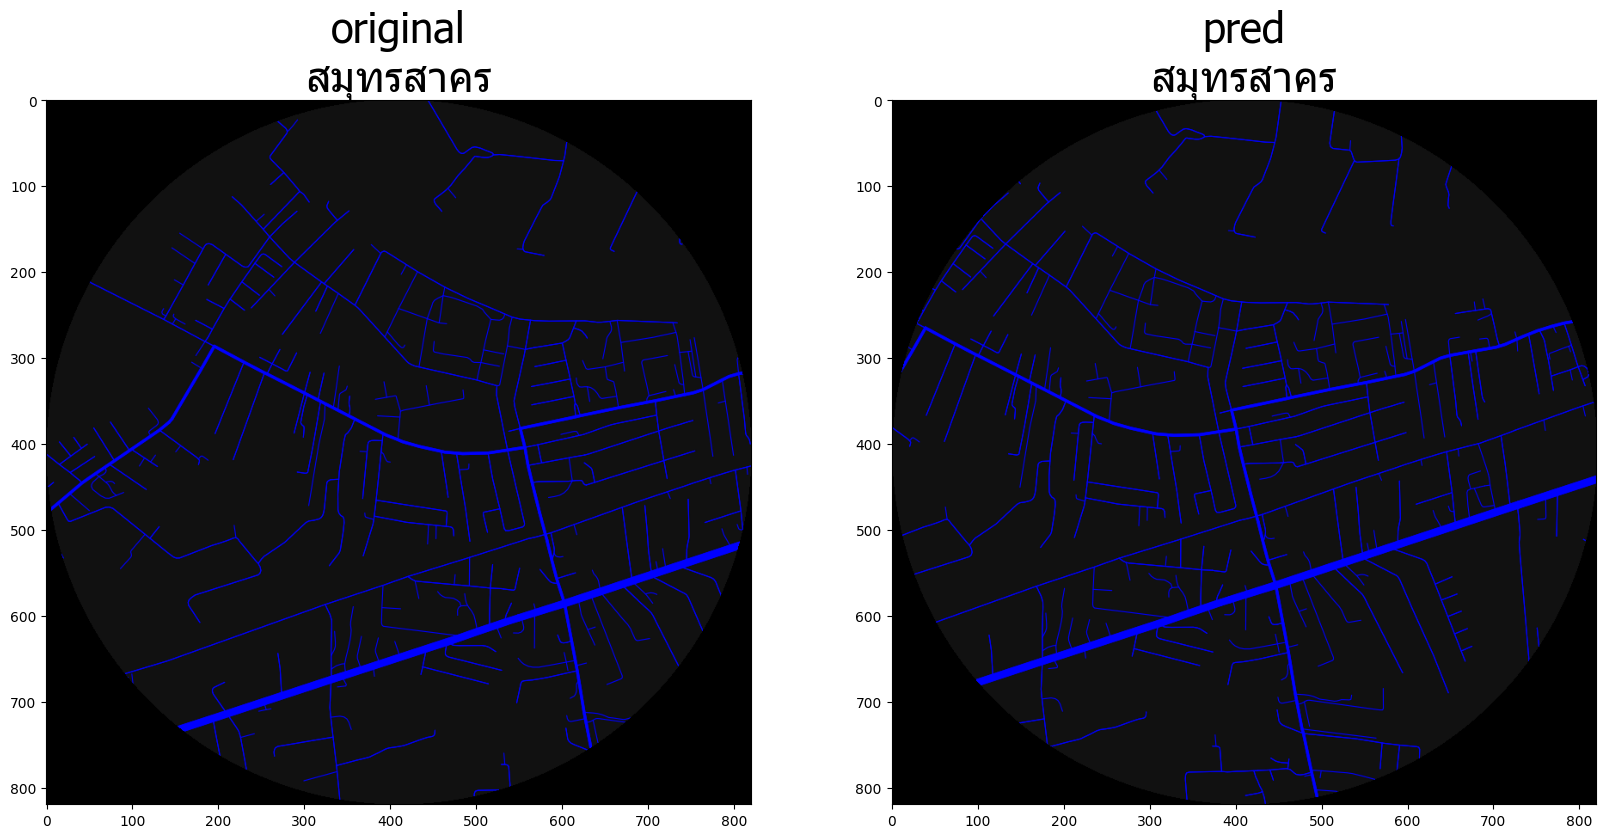

score : 828.2180786132812
prov_namt : สมุทรสาคร


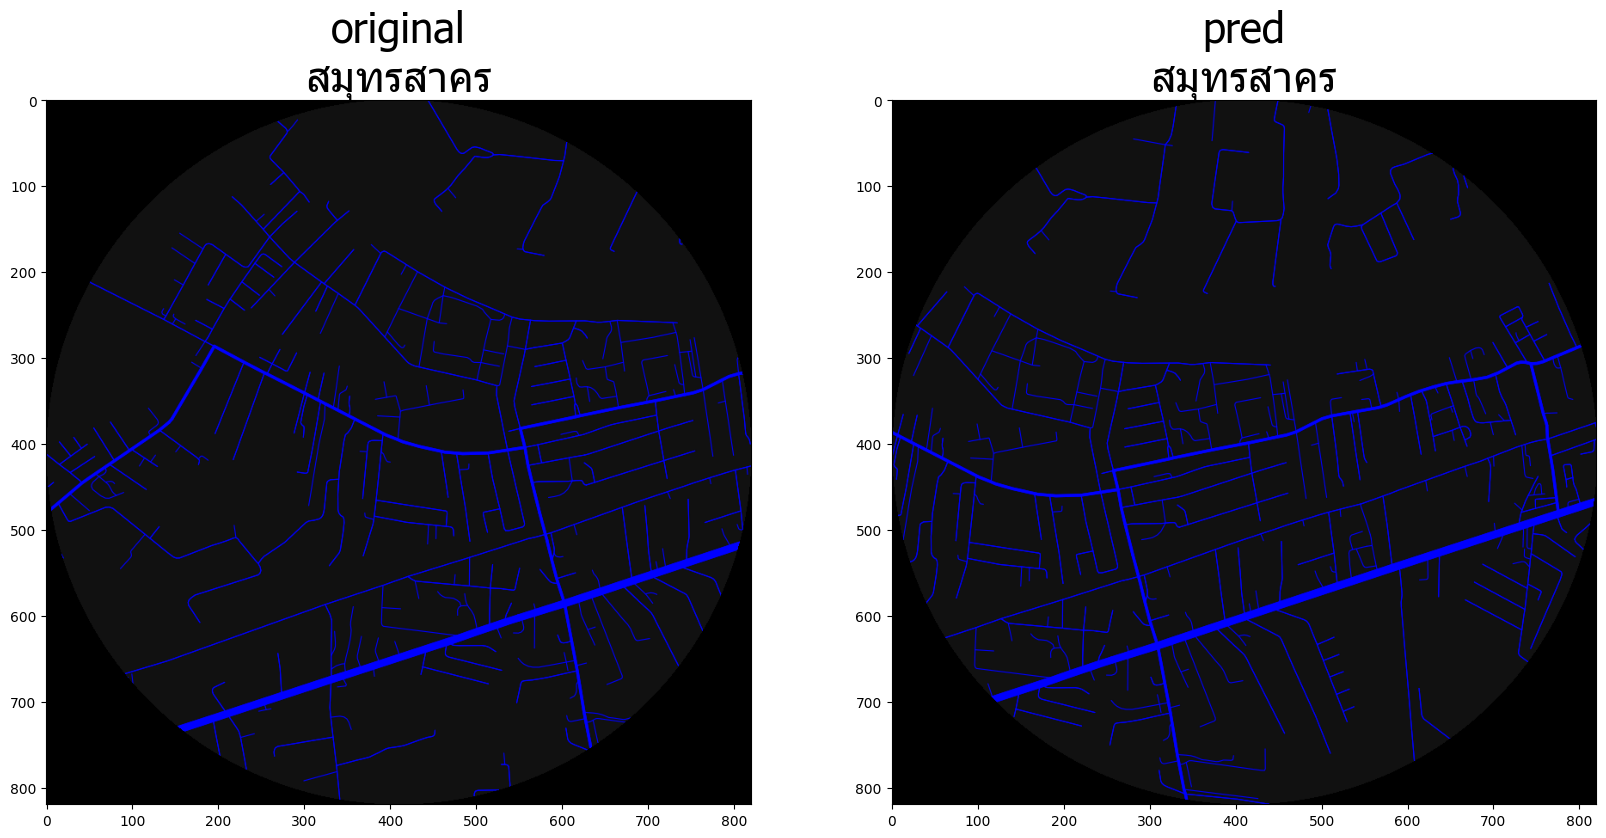

score : 887.3793334960938
prov_namt : สมุทรสาคร


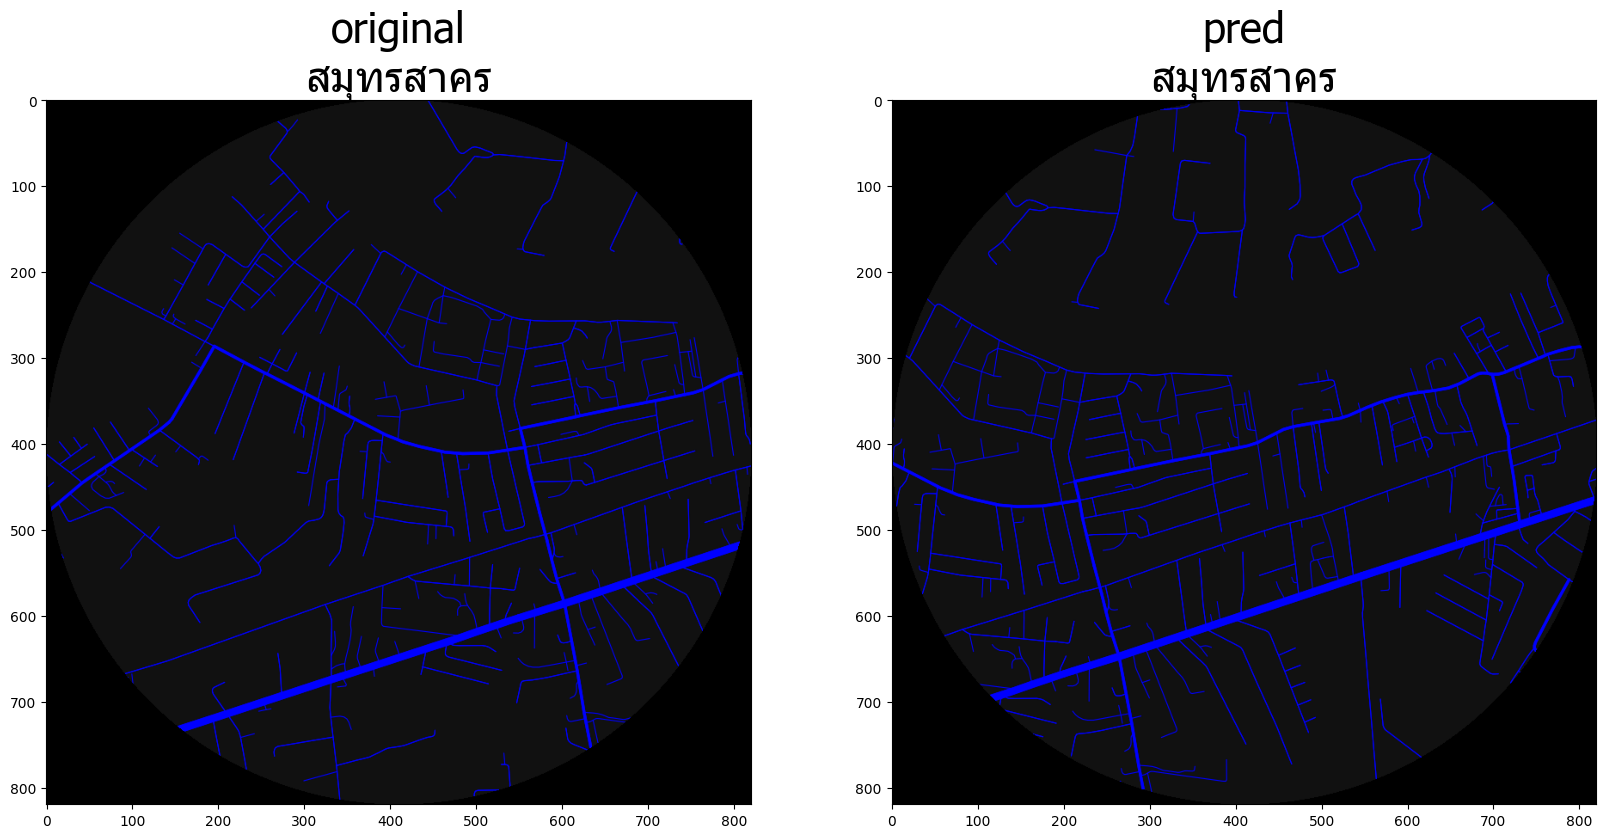

score : 944.7330932617188
prov_namt : สมุทรสาคร


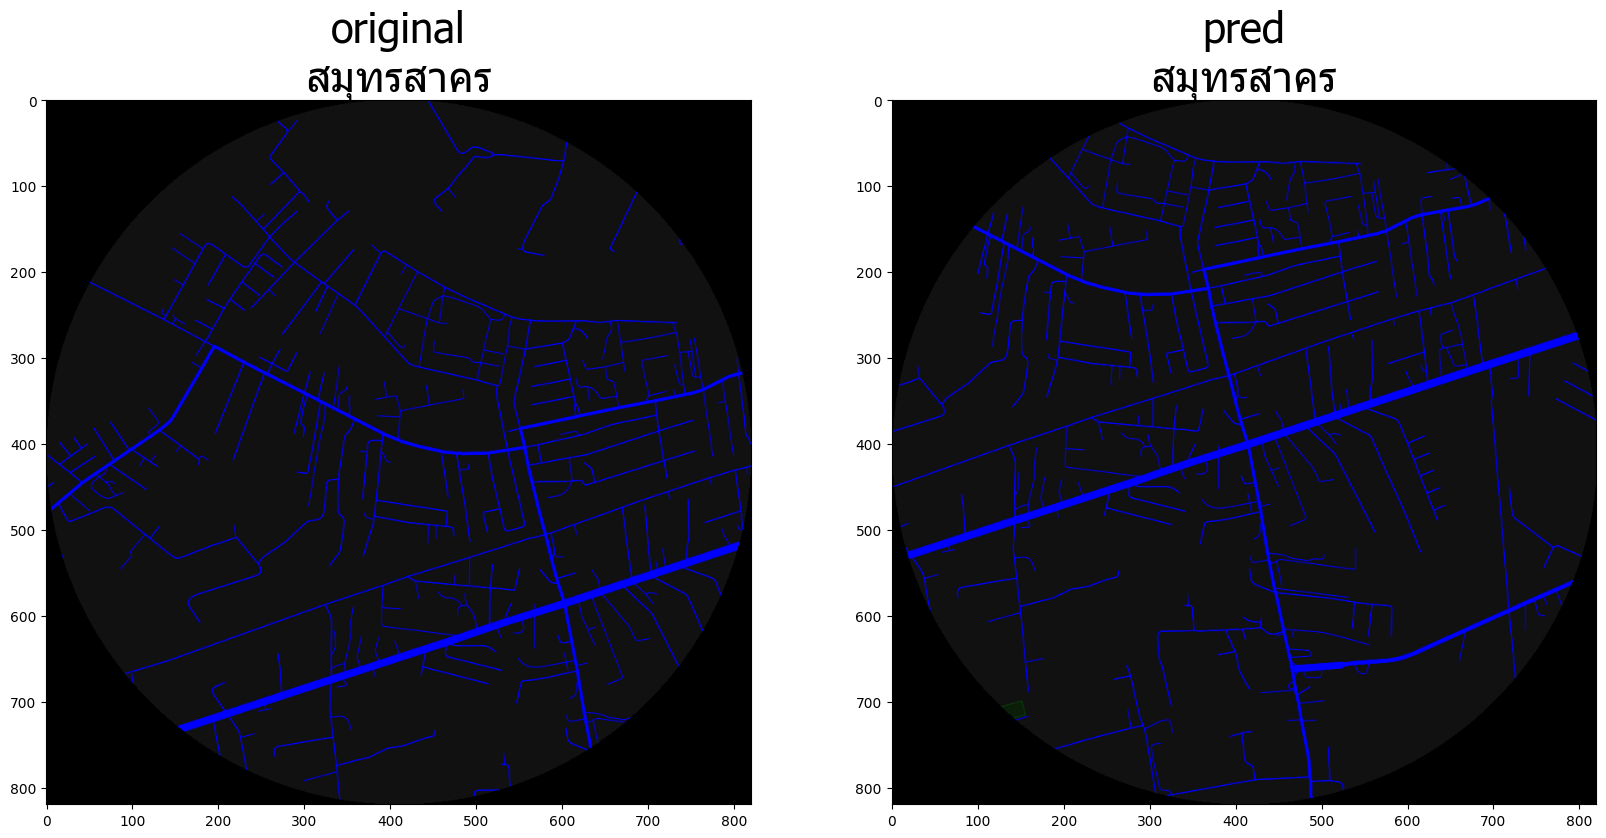

score : 1638.6251220703125
prov_namt : สงขลา


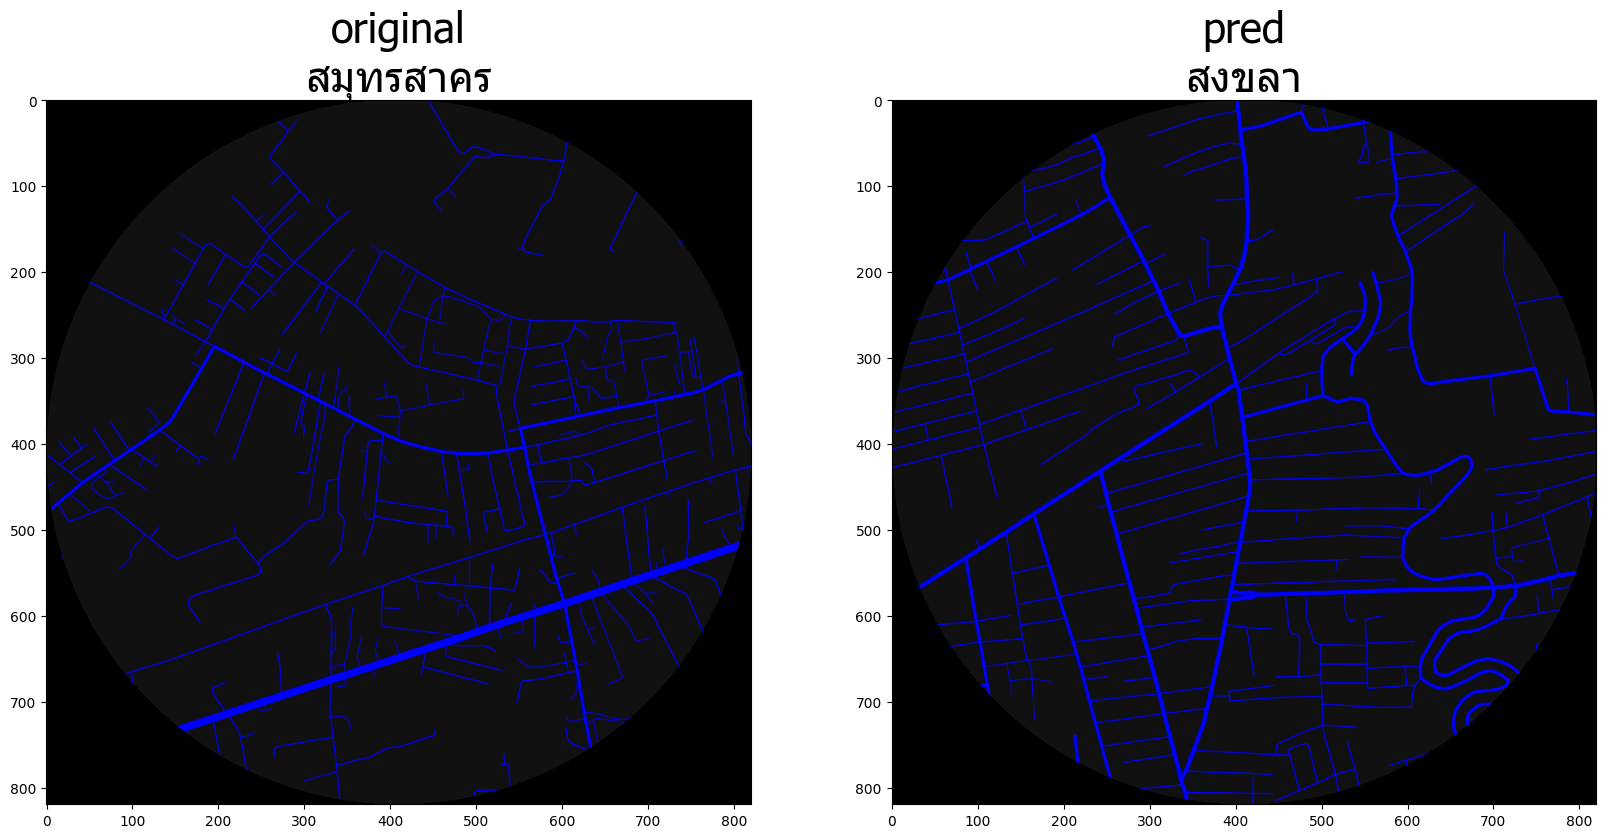

In [46]:
from PIL import Image
import matplotlib.pyplot as plt


def display_images(
    image_a,
    image_b,
    label_a,
    label_b,
    size=10,
    font_size=30,
    font_family="tahoma",
    save_path=None,
):
    # Create a 1x2 subplot grid
    plt.figure(figsize=(size * 2, size))

    # Plot the first image on the left
    plt.subplot(1, 2, 1)
    plt.imshow(image_a)
    plt.title(label_a, fontdict={"fontsize": font_size, "family": font_family})
    # plt.xlabel(score : 770.4474487304688"X-axis Label", fontdict={"fontsize": font_size, "family": font_family})

    # Plot the second image on the right
    plt.subplot(1, 2, 2)
    plt.imshow(image_b)
    plt.title(label_b, fontdict={"fontsize": font_size, "family": font_family})

    # Set font for x and y axis labels
    # plt.ylabel("Y-axis Label", fontdict={"fontsize": font_size, "family": font_family})

    # Adjust layout for better spacing
    # plt.tight_layout()

    # Show the plot
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()


def display_pred_from_result_dict(result_dict, size=10):
    df = result_dict["df"]
    print(result_dict["store_id"])
    print(result_dict["province"])
    original_image_path = result_dict["image_path"]
    ori_image = Image.open(original_image_path)

    pred = df["pred"].values
    for ind, p in enumerate(pred):
        score = df["score"].values[ind]
        prov_namt = df["prov_namt"].values[ind]
        print(f"score : {score}")
        print(f"prov_namt : {prov_namt}")
        image = Image.open(p)
        display_images(
            ori_image,
            image,
            f"original\n{result_dict['province']}",
            f"pred\n{prov_namt}",
            size=size,
            save_path=f"./p_jit/{result_dict['store_id']}_{ind}.png",
        )

        # break


result_dict = result_dict_list[9]

# break
display_pred_from_result_dict(result_dict)